<a href="https://colab.research.google.com/github/viniciusacosta/data-manipulation-exercises/blob/master/relatorio_inadimplencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relatório de Inadimplência — CPFs Únicos por Mês / Marca / Filial


**Objetivo**: Apurar CPFs únicos inadimplentes mês a mês por marca e filial.  
**Regra**: Um título conta em M se `vencimento ≤ EOM(M)` e (`status == "aberto"` ou (`status != "aberto"` e `baixa > EOM(M)`)).  
A contagem final é de CPFs distintos por mês/marca/filial.


## 1. Configuração & Carregamento de Dados

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

csv_path = r'/content/drive/MyDrive/Carreira/ELITE/teste_car_raiz_2025.csv'

raw = pd.read_csv(csv_path, sep=";", encoding="latin1", dtype=str)
raw.columns = [c.strip() for c in raw.columns]
raw.head()


,CODCOLIGADA,NOME,NOMEFANTASIA,MATRICULA,NOMEALUNO,REF,SACADO,CPF/CGC SACADO,PERIODOLETIVO,ANOMESCOMPETENCIA,...,VALORORIGINAL,VALORLIQUIDO,descricao,SERVICO,HISTORICO,LANÇAMENTO CRIADO POR,LANÇAMENTO CRIADO EM,CODAPLICACAO,VALORECEBIDO,MARCA
0,27,APOGEU DIVINOPOLIS LTDA,APOGEU DIVINOPOLIS LTDA,2712300702,PEDRO HENRIQUE PIRES GOMES,46874,Cinara Maria Pires,743.224.276-34,2024,2024/01,...,1396.38,1396.38,TOTVS Educacional,EF2 - Mensalidade,2712300702 - Pedro Henrique Pires Gomes - Serv...,amanda.lima,2023-10-10 16:33:02.000,S,1396.38,Apogeu
1,27,APOGEU DIVINOPOLIS LTDA,APOGEU DIVINOPOLIS LTDA,2712300702,PEDRO HENRIQUE PIRES GOMES,46877,Cinara Maria Pires,743.224.276-34,2024,2024/02,...,381.73,381.73,TOTVS Educacional,MD Interno - Ensino Fundamental 2,2712300702 - Pedro Henrique Pires Gomes - Serv...,amanda.lima,2023-10-10 16:33:05.000,S,381.73,Apogeu
2,27,APOGEU DIVINOPOLIS LTDA,APOGEU DIVINOPOLIS LTDA,2712300702,PEDRO HENRIQUE PIRES GOMES,46880,Cinara Maria Pires,743.224.276-34,2024,2024/04,...,1396.38,279.28,TOTVS Educacional,EF2 - Mensalidade,2712300702 - Pedro Henrique Pires Gomes - Serv...,amanda.lima,2023-10-10 16:33:08.000,S,279.28,Apogeu
3,27,APOGEU DIVINOPOLIS LTDA,APOGEU DIVINOPOLIS LTDA,2712300736,ISAAC SWERTS REZENDE,46932,Pollyne Camilo Swets Rezende,067.736.316-88,2024,2024/09,...,381.73,381.73,TOTVS Educacional,MD Interno - Ensino Fundamental 2,2712300736 - Isaac Swerts Rezende - Serviço: M...,amanda.lima,2023-10-11 10:13:48.000,S,NaN,Apogeu
4,27,APOGEU DIVINOPOLIS LTDA,APOGEU DIVINOPOLIS LTDA,2712300736,ISAAC SWERTS REZENDE,46935,Pollyne Camilo Swets Rezende,067.736.316-88,2024,2024/10,...,381.73,381.73,TOTVS Educacional,MD Interno - Ensino Fundamental 2,2712300736 - Isaac Swerts Rezende - Serviço: M...,amanda.lima,2023-10-11 10:13:50.000,S,NaN,Apogeu


## 2. Seleção, Normalização e Datas

In [3]:

df = raw[[
    'CPF/CGC SACADO','MARCA','NOMEFANTASIA','REF','VALORORIGINAL',
    'VENCIMENTO','STATUS','BAIXA'
]].copy()

df['cpf']    = df['CPF/CGC SACADO'].astype(str).str.replace(r'\D', '', regex=True).str.zfill(11)
df['marca']  = df['MARCA'].astype(str).str.strip()
df['filial'] = df['NOMEFANTASIA'].astype(str).str.strip()

df['vencimento'] = pd.to_datetime(df['VENCIMENTO'], errors='coerce', dayfirst=True)
df['baixa']      = pd.to_datetime(df['BAIXA'], errors='coerce', dayfirst=True)
df['status']     = df['STATUS'].astype(str).str.strip().str.lower()

df = df[~df['cpf'].isna() & ~df['vencimento'].isna()]
df.head()


,CPF/CGC SACADO,MARCA,NOMEFANTASIA,REF,VALORORIGINAL,VENCIMENTO,STATUS,BAIXA,cpf,marca,filial,vencimento,baixa,status
0,743.224.276-34,Apogeu,APOGEU DIVINOPOLIS LTDA,46874,1396.38,05/01/2024,BAIXADO,27/12/2023,74322427634,Apogeu,APOGEU DIVINOPOLIS LTDA,2024-01-05,2023-12-27,baixado
1,743.224.276-34,Apogeu,APOGEU DIVINOPOLIS LTDA,46877,381.73,05/02/2024,BAIXADO,29/01/2024,74322427634,Apogeu,APOGEU DIVINOPOLIS LTDA,2024-02-05,2024-01-29,baixado
2,743.224.276-34,Apogeu,APOGEU DIVINOPOLIS LTDA,46880,1396.38,05/04/2024,BAIXADO,27/03/2024,74322427634,Apogeu,APOGEU DIVINOPOLIS LTDA,2024-04-05,2024-03-27,baixado
3,067.736.316-88,Apogeu,APOGEU DIVINOPOLIS LTDA,46932,381.73,10/09/2024,EM ABERTO,NaN,06773631688,Apogeu,APOGEU DIVINOPOLIS LTDA,2024-09-10,NaT,em aberto
4,067.736.316-88,Apogeu,APOGEU DIVINOPOLIS LTDA,46935,381.73,10/10/2024,EM ABERTO,NaN,06773631688,Apogeu,APOGEU DIVINOPOLIS LTDA,2024-10-10,NaT,em aberto


## 3. Cálculo mês a mês e consolidações

In [11]:
# Linha do tempo
min_date = df['vencimento'].min()
max_date = pd.concat([df['vencimento'], df['baixa'].dropna()]).max()
if pd.isna(max_date):
    max_date = df['vencimento'].max()

start_month = pd.Timestamp(min_date.year, min_date.month, 1)
end_month   = pd.Timestamp(max_date.year, max_date.month, 1)
months = pd.period_range(start=start_month, end=end_month, freq='M')

# Vetorização
venc_i64  = df['vencimento'].values.astype('datetime64[ns]').astype('int64')
baixa_i64 = df['baixa'].values.astype('datetime64[ns]').astype('int64')
status_aberto = (df['status'].values == 'aberto')
baixa_notna = ~pd.isna(df['baixa']).values

rows = []
for per in months:
    eom = per.to_timestamp(how='end').to_datetime64()
    eom_i64 = eom.astype('datetime64[ns]').astype('int64')
    cond_venc = venc_i64 <= eom_i64
    cond_baixado_apos = (~status_aberto) & baixa_notna & (baixa_i64 > eom_i64)
    cond_aberto = status_aberto
    mask = cond_venc & (cond_aberto | cond_baixado_apos)
    if not mask.any():
        continue
    sub = df.loc[mask, ['cpf','marca','filial']]
    agg = (sub.groupby(['marca','filial'])['cpf']
           .nunique()
           .reset_index(name='cpfs_inadimplentes'))
    agg['mes_referencia'] = per.to_timestamp(how='start').strftime('%Y-%m')
    agg = agg[['mes_referencia','marca','filial','cpfs_inadimplentes']]
    rows.append(agg)

mensal_marca_filial = (pd.concat(rows, ignore_index=True)
                       if rows else
                       pd.DataFrame(columns=['mes_referencia','marca','filial','cpfs_inadimplentes']))
mensal_marca_filial = mensal_marca_filial.sort_values(['mes_referencia','marca','filial']).reset_index(drop=True)

mensal_marca = (mensal_marca_filial
                .groupby(['mes_referencia','marca'], as_index=False)['cpfs_inadimplentes']
                .sum()
                .rename(columns={'cpfs_inadimplentes':'cpfs_inadimplentes_marca'})
                .sort_values(['mes_referencia','marca'])
                .reset_index(drop=True))

mensal_marca_filial.head(10)


,mes_referencia,marca,filial,cpfs_inadimplentes
0,2023-01,Editora,EDITORA E LIVRARIA RAIZ EDUCAÇÃO LTDA,1
1,2023-01,Gloal Tree,CRECHE ESCOLA GLOBAL TREE - PENINSULA,1
2,2023-02,Editora,EDITORA E LIVRARIA RAIZ EDUCAÇÃO LTDA,1
3,2023-02,Gloal Tree,CRECHE ESCOLA GLOBAL TREE - PENINSULA,1
4,2023-02,Matriz,COLEGIO E CURSO MATRIZ EDUCACAO DUQUE DE CAXIAS,1
5,2023-03,Editora,EDITORA E LIVRARIA RAIZ EDUCAÇÃO LTDA,1
6,2023-03,Gloal Tree,CRECHE ESCOLA GLOBAL TREE - PENINSULA,1
7,2023-03,Matriz,COLEGIO E CURSO MATRIZ EDUCACAO DUQUE DE CAXIAS,1
8,2023-04,Editora,EDITORA E LIVRARIA RAIZ EDUCAÇÃO LTDA,1
9,2023-04,Gloal Tree,CRECHE ESCOLA GLOBAL TREE - PENINSULA,1


## 4. Visualizações

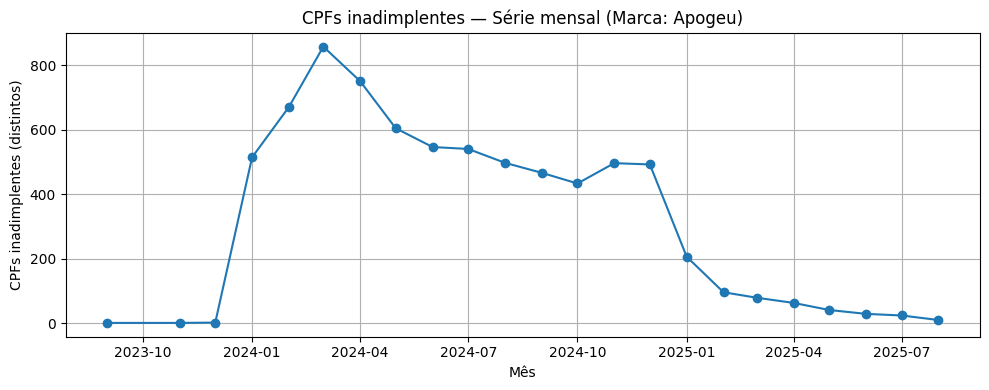

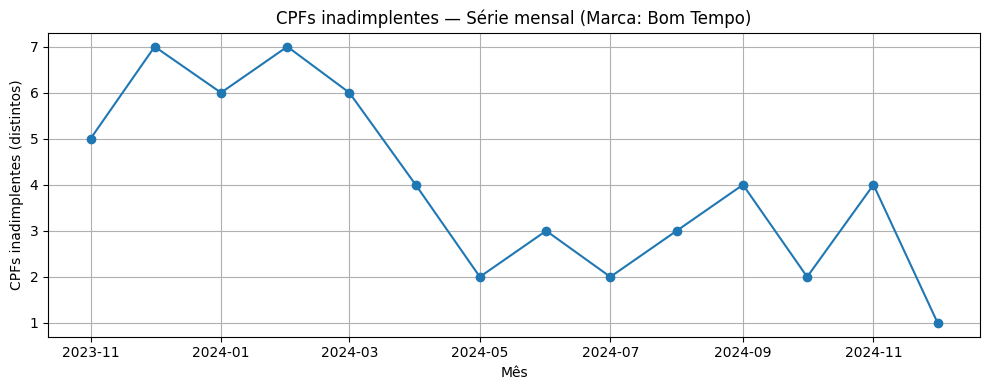

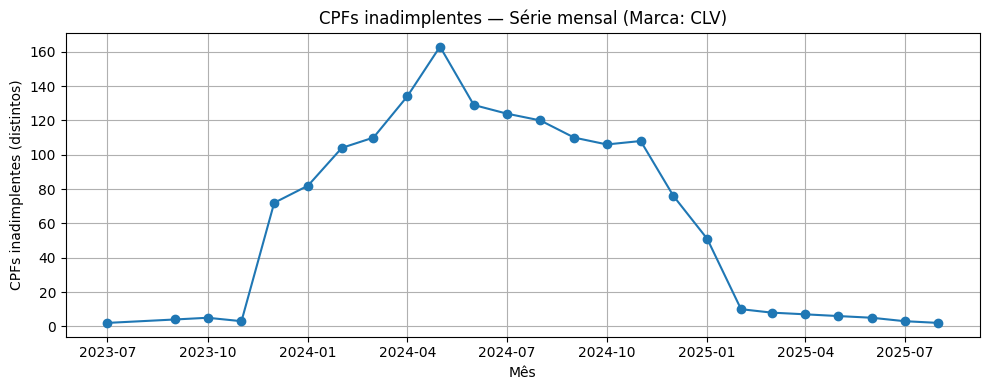

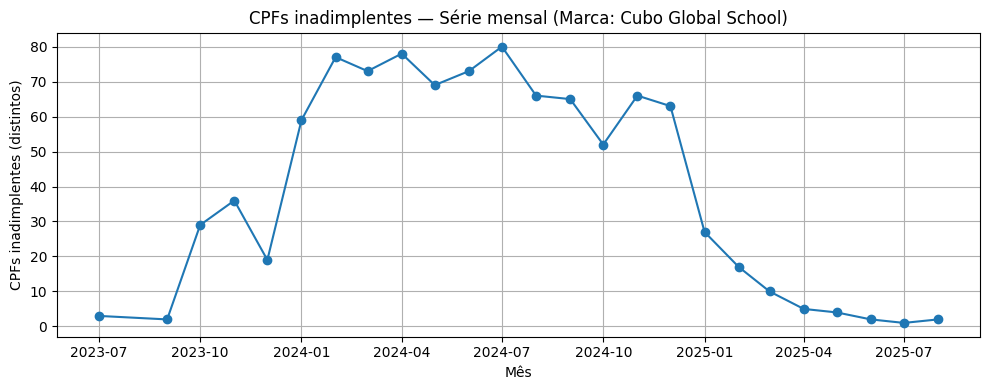

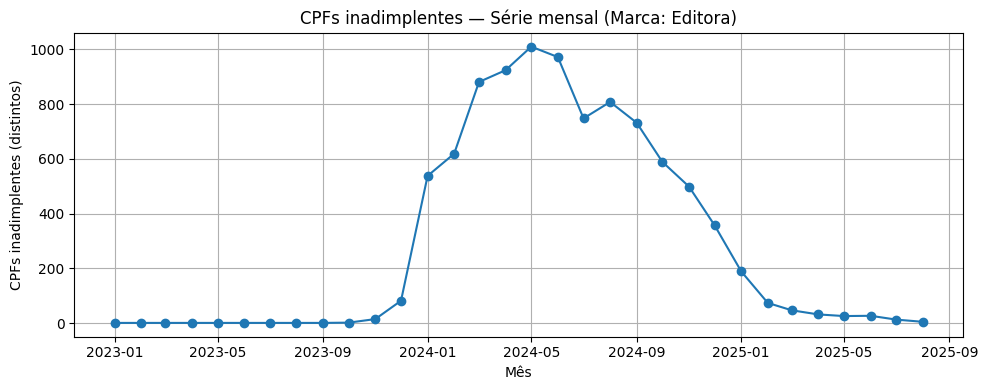

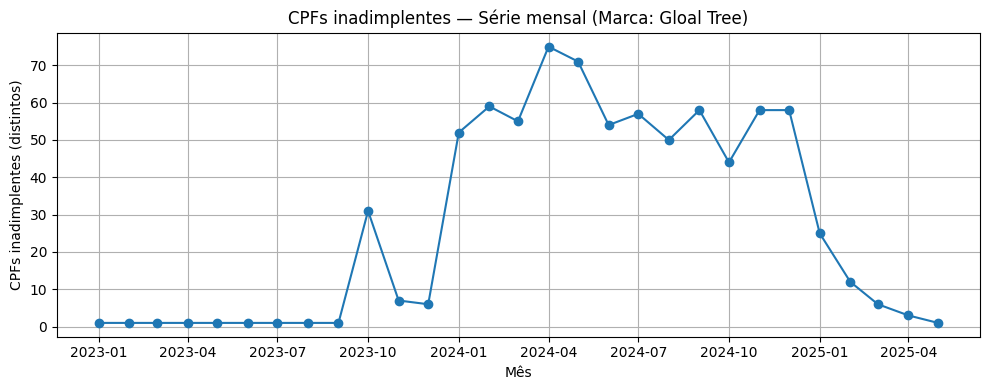

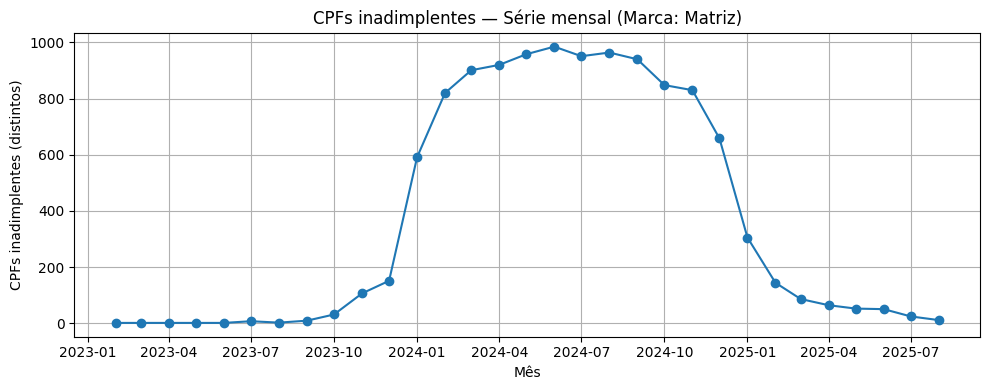

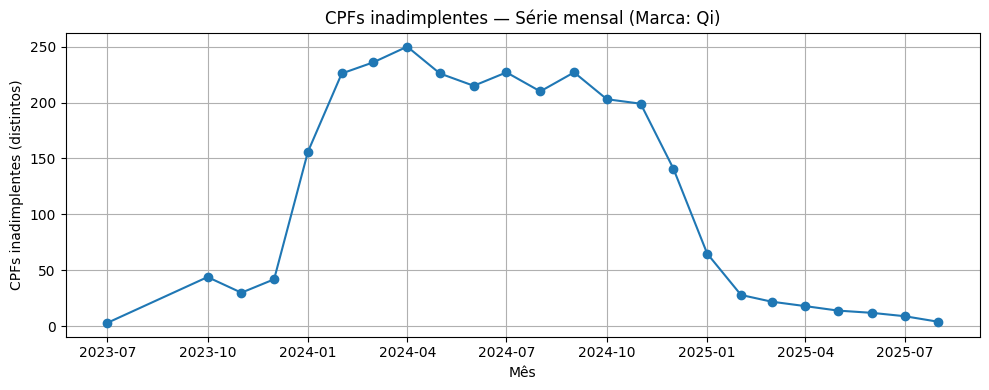

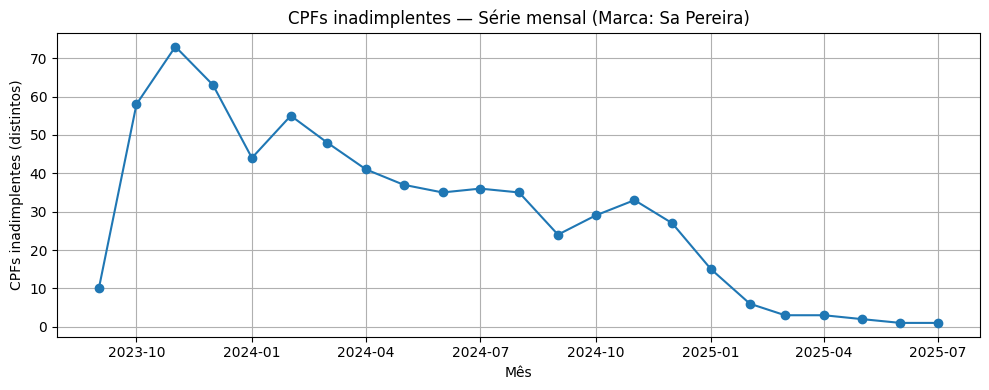

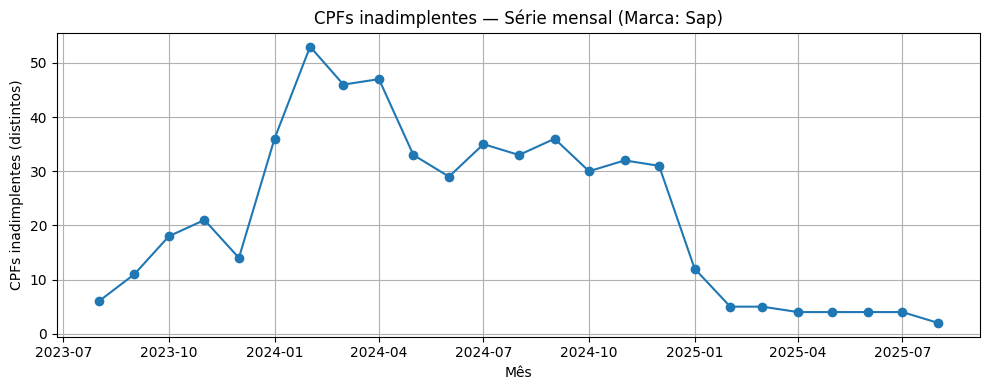

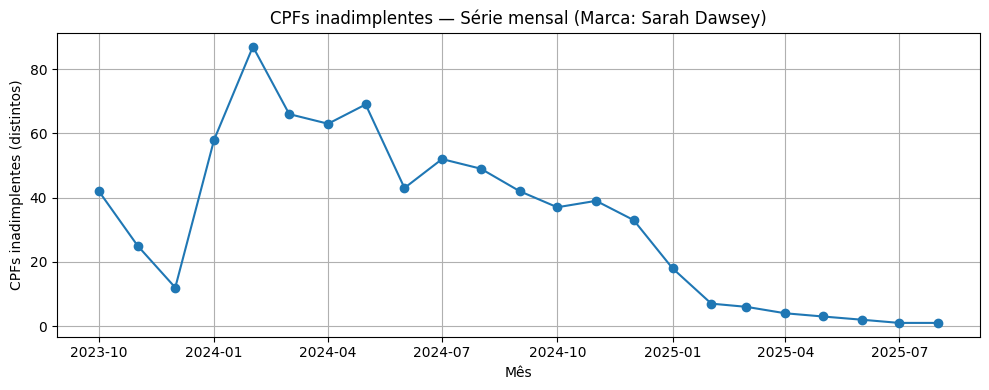

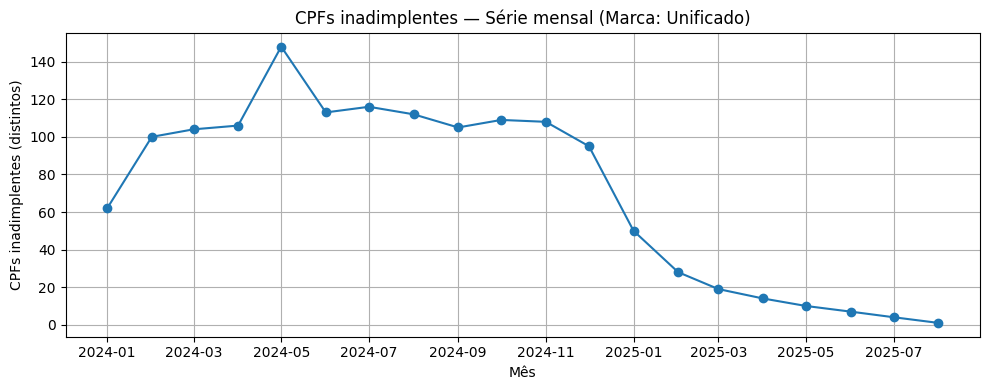

In [5]:

import matplotlib.pyplot as plt
import pandas as pd

# Série por marca (um gráfico por marca)
if not mensal_marca.empty:
    for marca, df_m in mensal_marca.groupby('marca'):
        plt.figure(figsize=(10,4))
        x = pd.to_datetime(df_m['mes_referencia'])
        y = df_m['cpfs_inadimplentes_marca']
        plt.plot(x, y, marker='o')
        plt.title(f'CPFs inadimplentes — Série mensal (Marca: {marca})')
        plt.xlabel('Mês')
        plt.ylabel('CPFs inadimplentes (distintos)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


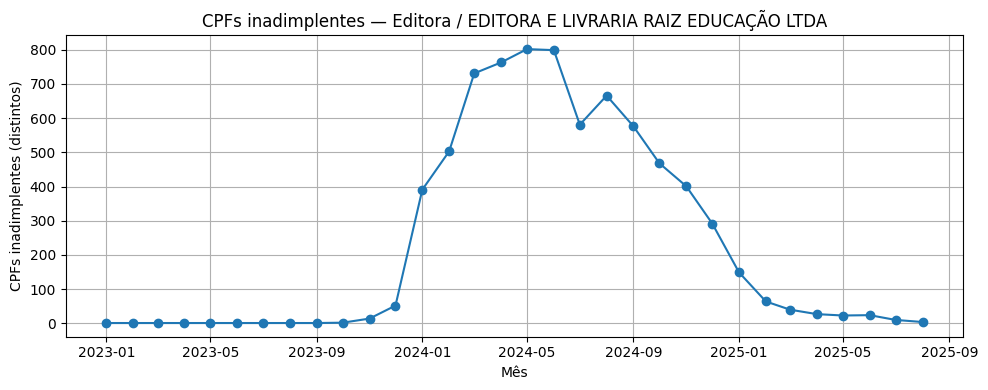

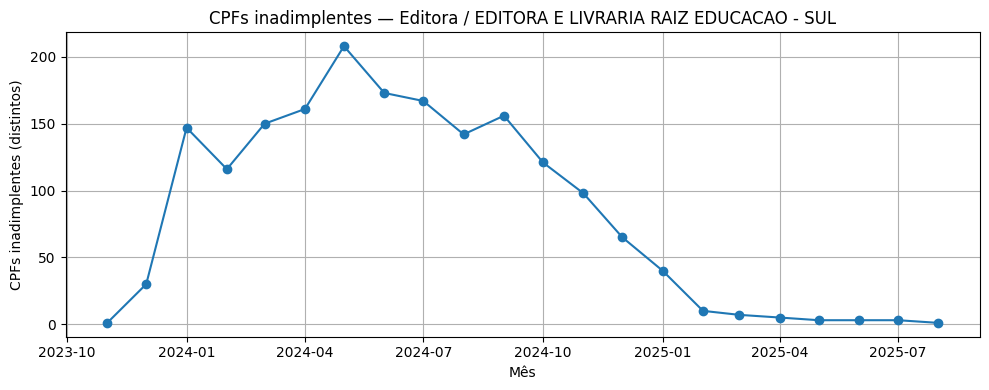

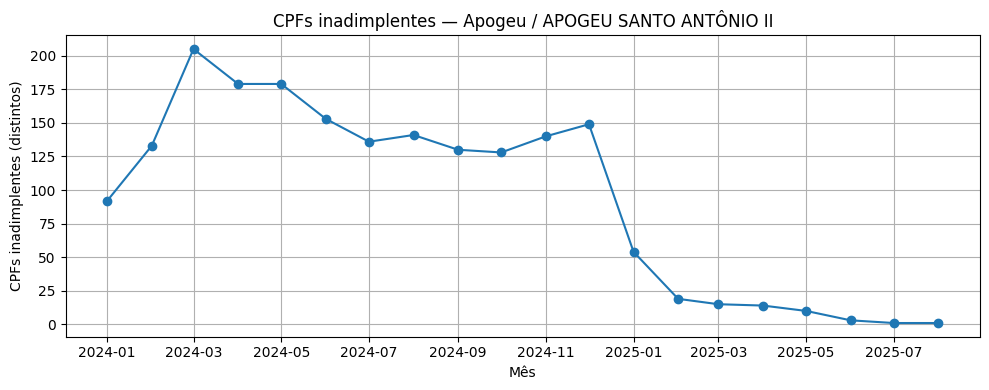

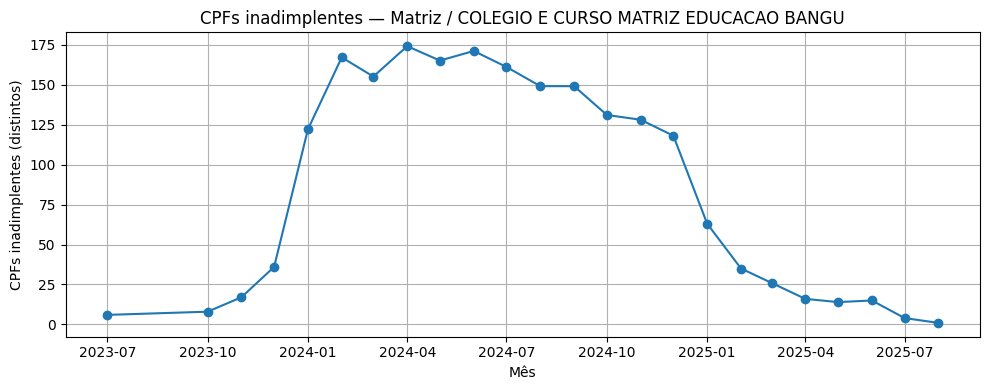

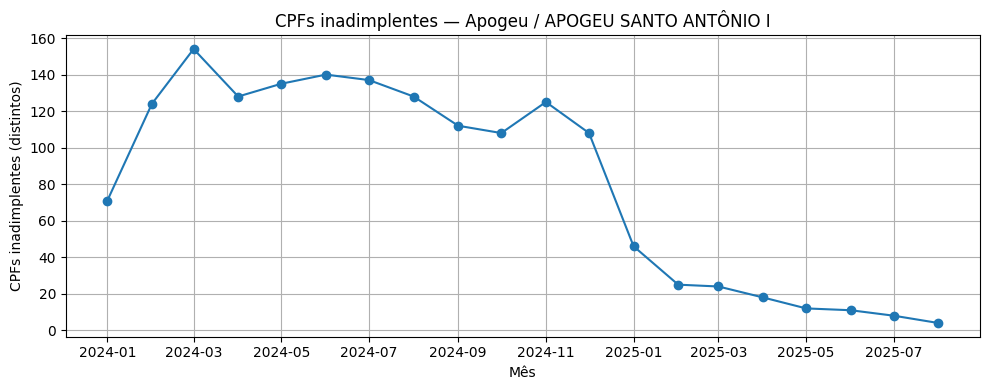

In [6]:

# Top 5 filiais por pico (um gráfico por filial)
if not mensal_marca_filial.empty:
    pico = (mensal_marca_filial
            .groupby(['marca','filial'])['cpfs_inadimplentes']
            .max()
            .reset_index()
            .sort_values('cpfs_inadimplentes', ascending=False)
            .head(5))
    for _, row in pico.iterrows():
        marca_sel = row['marca']
        filial_sel = row['filial']
        sub = mensal_marca_filial[(mensal_marca_filial['marca']==marca_sel) &
                                  (mensal_marca_filial['filial']==filial_sel)].copy()
        sub = sub.sort_values('mes_referencia')
        plt.figure(figsize=(10,4))
        x = pd.to_datetime(sub['mes_referencia'])
        y = sub['cpfs_inadimplentes']
        plt.plot(x, y, marker='o')
        plt.title(f'CPFs inadimplentes — {marca_sel} / {filial_sel}')
        plt.xlabel('Mês')
        plt.ylabel('CPFs inadimplentes (distintos)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


## 5. Auditoria (filtros por CPF/mês)

In [7]:
CPF_EXEMPLO = None       # '12345678901'
MARCA_EXEMPLO = None     # 'Apogeu'
FILIAL_EXEMPLO = None    # 'APOGEU DIVINOPOLIS LTDA'
MES_EXEMPLO = None       # '2023-08'

aud = df.copy()
if CPF_EXEMPLO:
    aud = aud[aud['cpf'] == CPF_EXEMPLO]
if MARCA_EXEMPLO:
    aud = aud[aud['marca'] == MARCA_EXEMPLO]
if FILIAL_EXEMPLO:
    aud = aud[aud['filial'] == FILIAL_EXEMPLO]

if MES_EXEMPLO:
    eom = pd.Period(MES_EXEMPLO).to_timestamp(how='end')
    cond = (aud['vencimento'] <= eom) & (
        (aud['status'] == 'aberto') |
        ((aud['status'] != 'aberto') & (aud['baixa'].notna()) & (aud['baixa'] > eom))
    )
    aud['conta_no_mes'] = cond

aud.sort_values(['cpf','vencimento','baixa']).head(50)


,CPF/CGC SACADO,MARCA,NOMEFANTASIA,REF,VALORORIGINAL,VENCIMENTO,STATUS,BAIXA,cpf,marca,filial,vencimento,baixa,status
407567,FISICA63197,Apogeu,SÃO TOMÁS DE AQUINO,95572,249.13,06/01/2024,EM ABERTO,NaN,00000063197,Apogeu,SÃO TOMÁS DE AQUINO,2024-01-06,NaT,em aberto
407745,FISICA63197,Apogeu,SÃO TOMÁS DE AQUINO,95573,249.13,06/02/2024,EM ABERTO,NaN,00000063197,Apogeu,SÃO TOMÁS DE AQUINO,2024-02-06,NaT,em aberto
407669,FISICA63197,Apogeu,SÃO TOMÁS DE AQUINO,95574,249.13,06/03/2024,EM ABERTO,NaN,00000063197,Apogeu,SÃO TOMÁS DE AQUINO,2024-03-06,NaT,em aberto
407670,FISICA63199,Apogeu,SÃO TOMÁS DE AQUINO,95629,66.04,14/01/2024,EM ABERTO,NaN,00000063199,Apogeu,SÃO TOMÁS DE AQUINO,2024-01-14,NaT,em aberto
407568,FISICA63199,Apogeu,SÃO TOMÁS DE AQUINO,95630,66.04,14/02/2024,EM ABERTO,NaN,00000063199,Apogeu,SÃO TOMÁS DE AQUINO,2024-02-14,NaT,em aberto
407752,FISICA63199,Apogeu,SÃO TOMÁS DE AQUINO,95631,66.04,14/03/2024,EM ABERTO,NaN,00000063199,Apogeu,SÃO TOMÁS DE AQUINO,2024-03-14,NaT,em aberto
407569,FISICA63503,Apogeu,SÃO TOMÁS DE AQUINO,97374,179.17,26/01/2024,EM ABERTO,NaN,00000063503,Apogeu,SÃO TOMÁS DE AQUINO,2024-01-26,NaT,em aberto
407753,FISICA63503,Apogeu,SÃO TOMÁS DE AQUINO,97375,179.17,26/02/2024,EM ABERTO,NaN,00000063503,Apogeu,SÃO TOMÁS DE AQUINO,2024-02-26,NaT,em aberto
407671,FISICA63503,Apogeu,SÃO TOMÁS DE AQUINO,97376,179.17,26/03/2024,EM ABERTO,NaN,00000063503,Apogeu,SÃO TOMÁS DE AQUINO,2024-03-26,NaT,em aberto
407570,FISICA63503,Apogeu,SÃO TOMÁS DE AQUINO,97377,179.17,26/04/2024,EM ABERTO,NaN,00000063503,Apogeu,SÃO TOMÁS DE AQUINO,2024-04-26,NaT,em aberto
